In [1]:
import torch
import numpy             as np
import matplotlib.pyplot as plt
import math

from sympy                    import *
from sympy                    import symbols, diff, simplify, exp, tanh, lambdify
from torch.optim              import Adam, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm                     import tqdm

init_printing()

***

# 1. Calculate expansion equation

In [7]:
# Run the file with all help functions

%run AppHor_conformal.ipynb

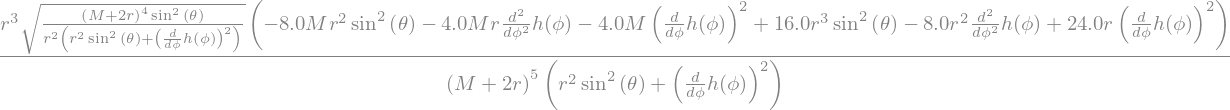

In [8]:
'''
Large function which calculates the expansion equation from alpha, beta, psi4, coordinates and h
'''



def final(alpha, beta, psi4, coords, h):
    '''
    param alpha: lapse function      --> function of (r, theta, phi)
    param beta: shift vector         --> 3-vector function of (r, theta, phi)
    param psi4: conformal factor     --> function of (r, theta, phi)
    param coords: coordinate system  --> list of coordinates
    param h: horizon function        --> scalar function dependent on theta, phi

    return: symbolic sympy expression of the expansion equation
    '''

    
    s_inv_norm = s_norm(h, s, psi4, coords, eta_inv)                       # inverse s-vector (normalized)
    
    christoffel = christoffel_symbols(psi4, eta, eta_inv, coords)       # Christoffel symbols of gamma 3-metric
    
    n_up = norm_up(alpha, beta, coords)                                 # normal vector to hypersurface (index up)
    
    n_down = norm_down(alpha, beta, psi4, eta, coords)                  # normal vector to hypersurface (index down)
    
    cur = extrinsic_curvature(n_up, n_down, christoffel, coords)        # extrinsic curvature (K_ij)
    
    exp = expansion(christoffel, s_inv_norm, cur, coords)               # expansion equation

    
    return exp



exp_eq = sp.simplify(final(alpha, beta, psi4, coords, h))
display(sp.simplify(exp_eq))

***

# 2. Convert symbolic expression to string (pytorch compatible)

In [9]:
'''
Function which replaces theta derivatives with symbols and converts to a string
'''



from sympy.printing.lambdarepr import lambdarepr

# Replace each theta derivative with a unique symbol for string conversion
def subs_der(expr, var):
    '''
    params expr: symbolic expression in which to replace derivatives
    params var: variable to which derivative is taken, i.e. theta or phi

    return: string with r replaced by H and derivatives replaced by symbols X, Y
    '''

    x = Function('x')(var)
    y = Function('y')(var)
    H, X, Y = symbols('H, X, Y')
    funcs = [h, x, y]
    syms = [H, X, Y]
    
    n = len(funcs)
    expr = expr.subs(r, h)
    for i in range(n-1):
        expr = expr.subs(diff(funcs[i], var), funcs[i+1])
    for i in range(n):
        expr = expr.subs(funcs[i], syms[i])
        
    return lambdarepr(expr)

***

# 3. PyTorch solver (phi case)

In [10]:
# Make string expression of theta expansion equation
expr_ph = subs_der(exp_eq, phi)

In [51]:
N_ph = 10
phi = torch.linspace(0, 2*torch.pi, N_ph, dtype=torch.float64)

h = torch.ones(N_ph, dtype=torch.float64, requires_grad=True)
h.data = 0.8*h.data

In [35]:
# Replace variables in string into torch format
dic_phi = {"math.sin(theta)":"1", "math.":"torch.", "sqrt":"torch.sqrt", "H":"h", "X":"(d_h)", "Y":"(d2_h)", "M":"2"}

def replace_all(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr_ph = replace_all(expr_ph, dic_phi)
print(expr_ph)

h**3*torch.torch.torch.torch.sqrt((2*h + 2)**4*1**2/(h**2*(h**2*1**2 + (d_h)**2)))*(16.0*h**3*1**2 - 8.0*h**2*2*1**2 - 8.0*h**2*(d2_h) - 4.0*h*2*(d2_h) + 24.0*h*(d_h)**2 - 4.0*2*(d_h)**2)/((2*h + 2)**5*(h**2*1**2 + (d_h)**2))


In [36]:
def h_loss(h, expr):
    # Define auxiliary variables
    d_ph = torch.mean(torch.diff(phi))

    # Define finite difference derivatives (periodic)
    d_h_pre = torch.diff(h, prepend=torch.Tensor([h[-2]]))/d_ph
    d_h_app = torch.diff(h, append=torch.Tensor([h[1]]))/d_ph
    d_h = 0.5 * (d_h_pre + d_h_app)
    d2_h_pre = torch.diff(d_h, prepend=torch.Tensor([d_h[-2]]))/d_ph
    d2_h_app = torch.diff(d_h, append=torch.Tensor([d_h[1]]))/d_ph
    d2_h = 0.5 * (d2_h_pre + d2_h_app)

    
    # Define residual of the equation by evaluating the string expression above
    residual = eval(expr)
    #residual = 2*(1.0/h - 1.0*2/(h**2*(1 + (1/2)*2/h)))*torch.sqrt(1/((1 + (1/2)*2/h)**(-4) + (d_h)**2/(h**2*(1 + (1/2)*2/h)**4*1**2)))/(1 + (1/2)*2/h)**4 + (1/2)*(-2*2/(h**2*(1 + (1/2)*2/h)**5) + 2*(d_h)**2/(h**3*(1 + (1/2)*2/h)**4*1**2) - 2*2*(d_h)**2/(h**4*(1 + (1/2)*2/h)**5*1**2))*torch.sqrt(1/((1 + (1/2)*2/h)**(-4) + (d_h)**2/(h**2*(1 + (1/2)*2/h)**4*1**2)))/((1 + (1/2)*2/h)**4*((1 + (1/2)*2/h)**(-4) + (d_h)**2/(h**2*(1 + (1/2)*2/h)**4*1**2))) + 1.0*2*torch.sqrt(1/((1 + (1/2)*2/h)**(-4) + (d_h)**2/(h**2*(1 + (1/2)*2/h)**4*1**2)))/(h**2*(1 + (1/2)*2/h)**5) - (d2_h)*torch.sqrt(1/((1 + (1/2)*2/h)**(-4) + (d_h)**2/(h**2*(1 + (1/2)*2/h)**4*1**2)))/(h**2*(1 + (1/2)*2/h)**4*1**2) + (d_h)**2*(d2_h)*torch.sqrt(1/((1 + (1/2)*2/h)**(-4) + (d_h)**2/(h**2*(1 + (1/2)*2/h)**4*1**2)))/(h**4*(1 + (1/2)*2/h)**8*((1 + (1/2)*2/h)**(-4) + (d_h)**2/(h**2*(1 + (1/2)*2/h)**4*1**2))*1**4)
    
    # Return the mean squared residual
    return torch.mean(residual**2)

In [37]:
def solve_for_h(h, expr, N_iter=1000, lr=1.0e-2):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([h], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.2, patience=50)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        loss      = h_loss(h, expr)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return h, losses

In [38]:
h, h_losses = solve_for_h(h, expr_ph, N_iter=1000, lr=1.0e-2)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 488.23it/s]


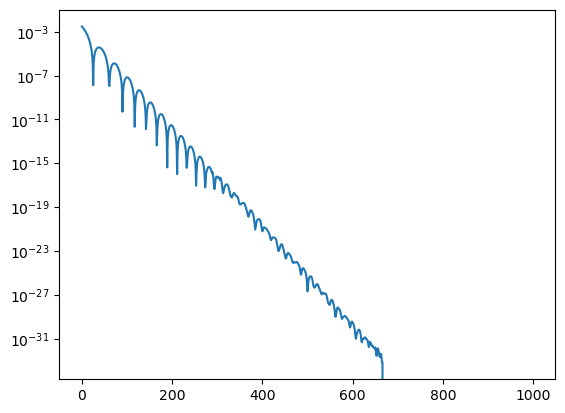

In [39]:
plt.plot(h_losses)
plt.yscale('log')

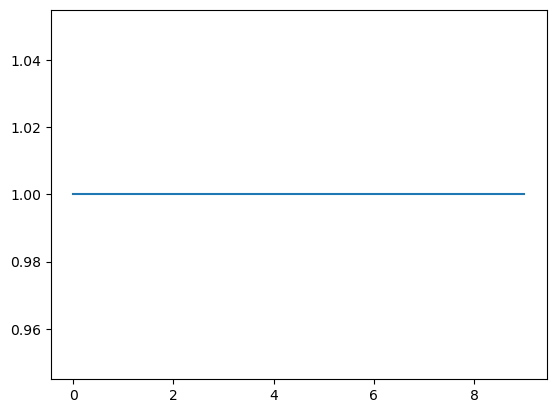

In [40]:
plt.plot(h.data);

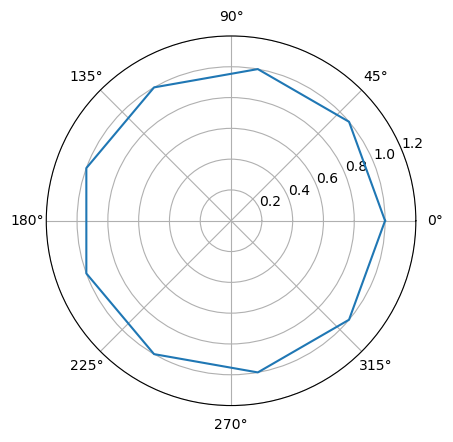

In [41]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi, h.data)
ax.set_rmax(1.2)
ax.grid(True)
plt.show()

# 4. PyTorch solver (theta case)

In [5]:
# Make string expression of theta expansion equation
expr_th = subs_der(exp_eq, theta)

In [61]:
N_th = 10
theta = torch.linspace(0, torch.pi, N_th, dtype=torch.float64)

h = torch.ones(N_th, dtype=torch.float64, requires_grad=True)
h.data = 0.9*h.data

In [62]:
# Replace variables in string into torch format
dic_theta = {"math.":"torch.", "sqrt":"torch.sqrt", "H":"h", "X":"(d_h)", "Y":"(d2_h)", "M":"2"}

def replace_all(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr_th = replace_all(expr_th, dic_theta)
print(expr_th)

h**2*torch.torch.torch.torch.torch.torch.torch.torch.torch.sqrt((2*h + 2)**4/(h**2*(h**2 + (d_h)**2)))*(16.0*h**4*torch.tan(theta) - 8.0*h**3*2*torch.tan(theta) - 8.0*h**3*(d_h) - 8.0*h**3*(d2_h)*torch.tan(theta) - 4.0*h**2*2*(d_h) - 4.0*h**2*2*(d2_h)*torch.tan(theta) + 24.0*h**2*(d_h)**2*torch.tan(theta) - 4.0*h*2*(d_h)**2*torch.tan(theta) - 8.0*h*(d_h)**3 - 4.0*2*(d_h)**3)/((2*h + 2)**5*(h**2 + (d_h)**2))


In [63]:
def h_loss(h, expr):
    # Define auxiliary variables
    d_th = torch.mean(torch.diff(theta))

    # Define finite difference derivatives (periodic)
    d_h_pre = torch.diff(h, prepend=torch.Tensor([h[1]]))/d_th
    d_h_app = torch.diff(h, append=torch.Tensor([h[-2]]))/d_th
    d_h = 0.5 * (d_h_pre + d_h_app)
    d2_h_pre = torch.diff(d_h, prepend=torch.Tensor([d_h[1]]))/d_th
    d2_h_app = torch.diff(d_h, append=torch.Tensor([d_h[-2]]))/d_th
    d2_h = 0.5 * (d2_h_pre + d2_h_app)

    
    # Define residual of the equation by evaluating the string expression above
    residual = eval(expr)
    #residual = 2*(1.0/h_2 - 1.0*2/(h_2**2*(1 + (1/2)*2/h_2)))*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(1 + (1/2)*2/h_2)**4 + (1/2)*(-2*2/(h_2**2*(1 + (1/2)*2/h_2)**5) + 2*(d_h/d_th)**2/(h_2**3*(1 + (1/2)*2/h_2)**4) - 2*2*(d_h/d_th)**2/(h_2**4*(1 + (1/2)*2/h_2)**5))*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/((1 + (1/2)*2/h_2)**4*((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4))) + 1.0*2*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(h_2**2*(1 + (1/2)*2/h_2)**5) - 1.0*(d_h/d_th)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))*torch.cos(th_2)/(h_2**2*(1 + (1/2)*2/h_2)**4*torch.sin(th_2)) - (d2_h/d_th)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(h_2**2*(1 + (1/2)*2/h_2)**4) + (d_h/d_th)**2*(d2_h/d_th)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(h_2**4*(1 + (1/2)*2/h_2)**8*((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))
    
    # Return the mean squared residual
    return torch.mean(residual**2)

In [64]:
def solve_for_h(h, expr, N_iter=1000, lr=1.0e-2):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([h], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.2, patience=50)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        loss      = h_loss(h, expr)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return h, losses

In [65]:
h, h_losses = solve_for_h(h, expr_th, N_iter=1000, lr=1.0e-2)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.48it/s]


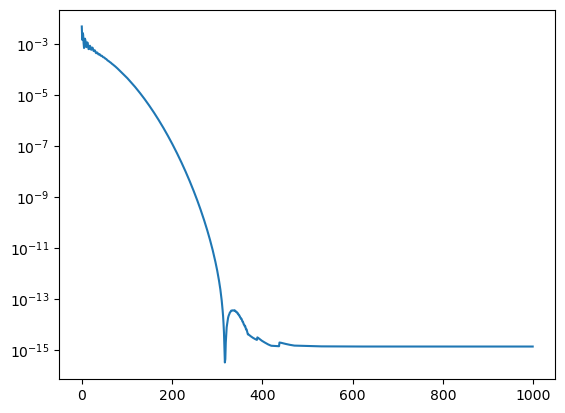

In [66]:
plt.plot(h_losses)
plt.yscale('log')

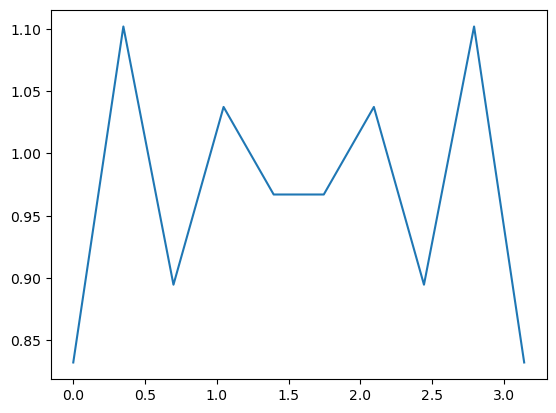

In [67]:
plt.plot(theta, h.data);

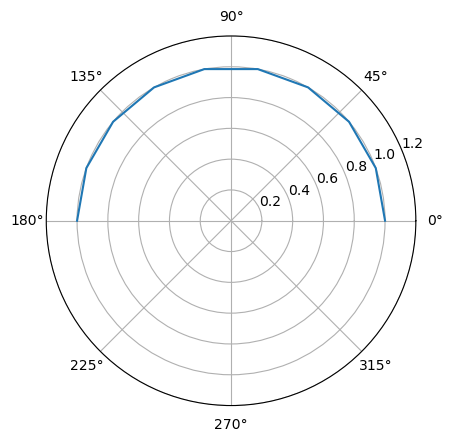

In [39]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, h.data)
ax.set_rmax(1.2)
ax.grid(True)
plt.show()

In [ ]:
def solve_for_h(h, expr, N_iter=150, lr=1.0e-2):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([h], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=200)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        rep, reg      = h_loss(h, expr)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss = rep + reg
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return h, losses

<hr style="border:2px solid gray">

<hr style="border:2px solid gray">

<hr style="border:2px solid gray">

# Backup

In [ ]:
'''
Function which replaces theta derivatives with symbols and converts to a string



from sympy.printing.lambdarepr import lambdarepr


# Define functions and symbols (--> up to 5th order derivatives can be replaced)
x = Function('x')(theta)
y = Function('y')(theta)
z = Function('z')(theta)
u = Function('u')(theta)
v = Function('v')(theta)
H, X, Y, Z, U, V = symbols('H, X, Y, Z, U, V')
funcs_pre = [h, x, y, z, u, v]
syms_pre = [H, X, Y, Z, U, V]


# Replace each theta derivative with a unique symbol for string conversion
def subs_der(expr, nr_der):
    '''
    params expr: symbolic expression in which to replace derivatives
    params nr_der: highest order of desired derivative to be replaced

    return: string with r replaced by H and derivatives replaced by symbols X, Y, ...
    '''
    
    funcs = []
    syms = []
    for i in range(nr_der+1):
        funcs.append(funcs_pre[i])
        syms.append(syms_pre[i])
    n = len(funcs)
    expr = expr.subs(r, h)
    for i in range(n-1):
        expr = expr.subs(diff(funcs[i], theta), funcs[i+1])
    for i in range(n):
        expr = expr.subs(funcs[i], syms[i])
        
    return lambdarepr(expr)

symp_expr = subs_der(exp_eq, 2)
print(symp_expr)
'''

In [ ]:
'''
# Theta linspace
N_th = 3
theta = torch.linspace(0.001, torch.pi, N_th, dtype=torch.float64)
#a = torch.tensor([theta[0]])
#theta_new = torch.cat((theta, a))  # Add first element at the back of the tensor

# Initialize h-function
h = torch.ones(N_th, dtype=torch.float64, requires_grad=True)
h.data = 0.4*h.data
b = torch.tensor([h[0]])
h_new = torch.cat((h, b))  # Add first element at the back of the tensor

print(h)
'''

'''
d_th = torch.diff(theta)
mean_th = torch.mean(d_th)
print(mean_th)

d_h = torch.diff(h_new)


c = torch.tensor([d_th[0]])
d_th_new = torch.cat((d_th, c))
d = torch.tensor([d_h[0]])
d_h_new = torch.cat((d_h, d))

d2_th = torch.diff(d_th_new)
d2_h = torch.diff(d_h_new)

print(theta.shape, h.shape, d_th.shape, d_h.shape, d2_th.shape, d2_h.shape)
'''

'''
dic_solve = {"H":"h", "X":"(d_h/mean_th)", "Y":"(d2_h/mean_th)", "M":"1", "theta":"1"}
#dic_solve = {"H":"h", "X":"(d_h/d_th)", "Y":"0", "M":"1"}

def replace_solve(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr = replace_all(expr, dic_solve)
print(expr)
'''

In [ ]:
'''
Function which makes the string pytorch-compatible



#dic = {"math.sin(theta)":"1", "math.":"torch.", "sqrt":"torch.sqrt"}   # phi case (take sin(theta)=1)
dic = {"math.":"torch.", "sqrt":"torch.sqrt"}   # theta case

def replace_all(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr = replace_all(symp_expr, dic)
#test_repl = replace_all(test, dic)

print(expr)
'''

***

# Old solver

In [9]:
Nr = 1
r = torch.ones(Nr, dtype=torch.float64, requires_grad=True)

def r_loss(r):
    # Define residual of the equation
    residual = 1/r**5 * ((r-1.5) * (1+2*r)**3)
    # Return the mean squared residual
    return torch.mean(residual**2)

In [10]:
def solve_for_r(r, N_iter=1000, lr=1.0e-3):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([r], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=200)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        loss      = r_loss(r=r)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return r, losses

In [11]:
r, r_losses = solve_for_r(r=r, N_iter=10000, lr=1.0e-3)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1385.57it/s]


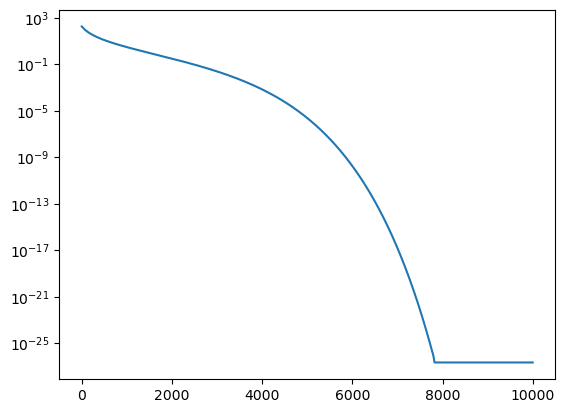

In [12]:
plt.plot(r_losses)
plt.yscale('log')

In [14]:
print(r)

tensor([1.5000], dtype=torch.float64, requires_grad=True)
